In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Look at the data

In [3]:
trump_path = Path('data/mrtrump')
trump_path.ls()

[PosixPath('data/mrtrump/MrTrumpSpeeches.csv'),
 PosixPath('data/mrtrump/models'),
 PosixPath('data/mrtrump/MrTrumpSpeeches_preview.csv'),
 PosixPath('data/mrtrump/data_lm.pkl')]

In [4]:
df = pd.read_csv(trump_path/'MrTrumpSpeeches_preview.csv')
df.head()

,id,playlist,upload_date,title,view_count,average_rating,like_count,dislike_count,subtitles
0,-2WTNSujhjk,Donald Trump Speeches & Events,20160220,Live Stream: Donald Trump Victory Rally in Spa...,4057.0,4.259259,44.0,10.0,presidents of the United States mr. go tr...
1,-64nfy6i58w,Donald Trump Speeches & Events,20161107,LAST RALLY: Donald Trump FINAL CAMPAIGN Rally ...,47276.0,4.358025,952.0,182.0,it's now officially Tuesday November a di...
2,-7Sp31hTxkU,Donald Trump Speeches & Events,20160423,FULL SPEECH: Donald Trump Rally in Bridgeport ...,19966.0,4.666667,220.0,20.0,you [Music] [Music] [Music] you I...


In [5]:
df['subtitles'][0]

"   presidents of the United States mr. go   trapp family   you   you   thank you   [Applause]   [Music]   everybody well I want to begin by   thanking the people of South Carolina   this is a special state thank you these   are special people and you know we get a   little boost last week from a place we   all remember New Hampshire we can't   forget it special special we love it and   they sent us in here with a very good   feeling right very good feeling so I   really want to thank you and my   volunteers all of these people   volunteers and and they travel and they   go I say what are you doing and now   they're going to Texas and they're going   all over some are going to Nevada I'll   be going to Nevada we're making a big   speech tomorrow in Atlanta and then   we're going right to Nevada and I think   we're going to do terrific there and the   SEC is going to be very very exciting we   expect it to very very well I want to   just say thank you to my family it's   been not easy f

Perhaps we should we remove tokens such as [applause], [music], etc. Let's roll with them for now, it could be fun.

## Read whole file to create a language model

Reading the csv directly fails, we need to help a little bit with a few options.

In [6]:
dataframe = pd.read_csv(trump_path/'MrTrumpSpeeches.csv', header=0, delimiter="\~", quoting=3, engine='python')

In [7]:
print(dataframe.shape)
print(dataframe.columns)
print(dataframe.head())

(836, 9)
Index(['id', 'playlist', 'upload_date', 'title', 'view_count',
       'average_rating', 'like_count', 'dislike_count', 'subtitles'],
      dtype='object')
            id                        playlist  upload_date  \
0  -2WTNSujhjk  Donald Trump Speeches & Events     20160220   
1  -64nfy6i58w  Donald Trump Speeches & Events     20161107   
2  -7Sp31hTxkU  Donald Trump Speeches & Events     20160423   
3  -byuyavcNI4  Donald Trump Speeches & Events     20160617   
4  09BXh-AA72M  Donald Trump Speeches & Events     20161105   

                                               title  view_count  \
0  Live Stream: Donald Trump Victory Rally in Spa...      4057.0   
1  LAST RALLY: Donald Trump FINAL CAMPAIGN Rally ...     47276.0   
2  FULL SPEECH: Donald Trump Rally in Bridgeport,...     19966.0   
3  Full Speech: Donald Trump Rally in Houston, Te...     15138.0   
4  Full Speech: Donald Trump Rally in Denver, Col...      8720.0   

   average_rating  like_count  dislike_count  \


In [8]:
bs=50

In [9]:
data_lm = (TextList.from_df(dataframe, path=trump_path, cols='subtitles')
              .random_split_by_pct(0.1)
              .label_for_lm()
               .databunch(bs=bs))

In [10]:
# Save for later
data_lm.save('data_lm.pkl')

In [11]:
data_lm.show_batch()

idx,text
0,hampshire we ca n't forget it special special we love it and they sent us in here with a very good feeling right very good feeling so i really want to thank you and my volunteers all of these people volunteers and and they travel and they go i say what are you doing and now they 're going to xxmaj texas and they 're going all over some are
1,i always used to say for months now i 've been saying i 'll take rights over xxmaj debbie and everyone said oh but xxmaj debbie 's a superstar said so his rights and then it turned out that xxmaj debbie flamed out and she 's gone but the disloyalty was incredible and i really mean that because honestly whether you like her or not she worked very hard to
2,thirty - five percent income taxes will be cut dramatically for the workers of workers that i mean the really hard workers you 're paying too much tax folks everybody knows it so for the workers the middle - class families everybody we 're having a major major tax reductions and i will tell you xxmaj ivanka xxmaj trump wants child care taken care of and we 're going to
3,that we think we have all of us somebody somebody gets a good job and you do n't have the problems but we 're having our jobs ripped off and being sent to other countries ripped off by currency manipulation where they 're lowering the value of their currency and they 're making it impossible for our companies to compete we 're being ripped off at every level and we
4,enjoy your new plant the weather 's hot but that 's okay enjoy the new plan but if you move there 's going to be this text they 're not going to move folks they 're not going to move they 're going to say well we 're gon na stay now they 'll stay in xxmaj indiana they may come to xxmaj north xxmaj carolina all of that stuff


In [12]:
len(data_lm.vocab.itos)

11895

## Load pretrained language model

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [14]:
AWD_LSTM??

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.31E-02


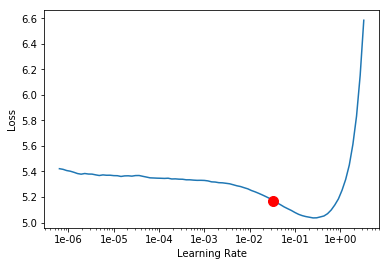

In [16]:
learn.recorder.plot()

Min numerical gradient: 3.31E-02


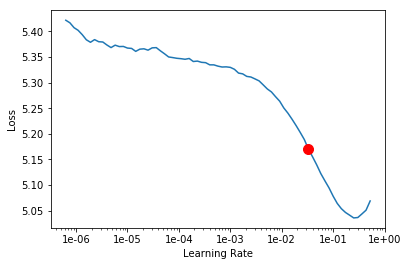

In [17]:
learn.recorder.plot(skip_end=15)

In [18]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,3.831092,3.817893,0.282857


In [19]:
learn.save('fit_head')

## Unfreeze to fine-tune

In [20]:
learn.unfreeze()

In [21]:
torch.cuda.empty_cache()

In [22]:
learn.fit_one_cycle(10, 3e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,3.495352,3.657011,0.304301
2,3.330906,3.534734,0.322778
3,3.146074,3.436176,0.339162
4,2.865780,3.355327,0.353184
5,2.581101,3.287690,0.369105
6,2.235302,3.265190,0.382026
7,2.129893,3.207923,0.395707
8,1.826912,3.201088,0.404609
9,1.758937,3.204947,0.409011
10,1.657858,3.214163,0.410677


In [23]:
learn.save('fine_tuned')

In [24]:
learn.save_encoder('fine_tuned_encoder')

In [25]:
TEXT = 'We need to build a wall'
N_WORDS = 100
N_SENTENCES = 1

In [26]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

We need to build a wall and Mexico will pay for the wall that we 're talking about and the wall is going to cost the United States tremendous amounts of money to build it from the Gulf Coast but i 'll tell you we have a very depleted military we have great military and we ca n't allow it to happen we will build the wall we 're going to build a wall and who is going to pay for the wall who one hundred percent they 're not going to pay for the world they 're not going to


In [27]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

We need to build a wall it 's going to be a real wall and Mexico will pay for the wall you know we have a real wall you know when they say we wo n't pay for the world we do n't know if they want to pay for the wall so we 're gon na have a wall we 're going to have a wall we are going to stop drugs from coming pouring into this country we 're going to stop people from coming into our country that we love we do n't know where these are people guess what 's going


In [28]:
TEXT = 'Hillary Clinton'
N_WORDS = 100
N_SENTENCES = 1

In [29]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Hillary Clinton has been a countless instance in the presidential on this issue of trade and renewal of this country as a country that is due to her energy policies that have blocked all the coal mines and shut down the mines and i 'm not sure that they could be the true ones because she is the only one who has a good relationship with Hillary Clinton but the only thing she can sign is to increase the number of jobs producing by American energy not by American power or create massive coal production now i 'm


In [30]:
def generate_phrase(seed, nwords=100):
    return learn.predict(seed, nwords, temperature=0.75)

In [31]:
generate_phrase('Steve Bannon')

"Steve Bannon and Steve Bannon and MSNBC chief legal correspondent ari melber thank you yeah john yeah it 's a very good group of people that i think a lot of people are getting ahead of or getting ahead of schedule so we 're going to be speaking with the Attorney General so and we are going to do something that 's going to be very special and i think we 're going to do very very well in November that we are going to have to blow a big deal that 's going to be"

In [32]:
generate_phrase('Hillary Clinton')

"Hillary Clinton does not have a chance and what she 's done in Libya what she wanted to do is look at Syria look at the migration you look at her plan look at her plan for the inner cities to give us a break Hillary Clinton supports Obamacare and wants to expand it you 've seen it for years it 's going to happen and it does n't work that way anymore it 's not going to happen either we win this election or we lose our country with a government that serves the people every"